In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, confusion_matrix
import re
import seaborn as sns

In [2]:
# Load dataset
aspects_df = pd.read_csv('semeval2014-1.csv')

In [3]:
aspects_df.shape

(3055, 7)

In [4]:
# Get the information regarding the data
aspects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3055 entries, 0 to 3054
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   text                     3055 non-null   object
 1   service                  3055 non-null   int64 
 2   food                     3055 non-null   int64 
 3   anecdotes/miscellaneous  3055 non-null   int64 
 4   price                    3055 non-null   int64 
 5   ambience                 3055 non-null   int64 
 6   review                   3055 non-null   object
dtypes: int64(5), object(2)
memory usage: 167.2+ KB


In [5]:
# Check Null values in the dataset
aspects_df.isnull()

,text,service,food,anecdotes/miscellaneous,price,ambience,review
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
3050,False,False,False,False,False,False,False
3051,False,False,False,False,False,False,False
3052,False,False,False,False,False,False,False
3053,False,False,False,False,False,False,False


In [6]:
aspects_df.isnull().sum()

text                       0
service                    0
food                       0
anecdotes/miscellaneous    0
price                      0
ambience                   0
review                     0
dtype: int64

In [7]:
# To learn about the statistics about the data 
aspects_df.describe()

,service,food,anecdotes/miscellaneous,price,ambience
count,3055.000000,3055.000000,3055.000000,3055.000000,3055.000000
mean,0.196072,0.403928,0.370540,0.106710,0.141735
std,0.397089,0.490764,0.483028,0.308795,0.348835
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Drop unimportant columns

aspects_df.columns

Index(['text', 'service', 'food', 'anecdotes/miscellaneous', 'price',
       'ambience', 'review'],
      dtype='object')

In [9]:
aspects_df.head(5)

,text,service,food,anecdotes/miscellaneous,price,ambience,review
0,but the staff was so horrible to us,1,0,0,0,0,negative
1,to be completely fair the only redeeming facto...,0,1,1,0,0,neutral
2,the food is uniformly exceptional with a very ...,0,1,0,0,0,positive
3,where gabriela personaly greets you and recomm...,1,0,0,0,0,positive
4,for those that go once and dont enjoy it all i...,0,0,1,0,0,neutral


In [10]:
# Aspect labels
aspect_labels = ["service", "food", "anecdotes/miscellaneous", "price", "ambience"]

In [11]:
# Function to handle contractions and negations
def preprocess_text(text):
    # Define contractions
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "shan't": "shall not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }

    # Replace contractions
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text)

    # Handle negations
    negations = ["not", "never", "no", "none", "nobody", "nothing", "neither", "nowhere", "hardly", "scarcely", "barely", "cannot"]
    text_tokens = text.split()
    for i in range(len(text_tokens) - 1):
        if text_tokens[i] in negations:
            text_tokens[i + 1] = "NOT_" + text_tokens[i + 1]

    return " ".join(text_tokens)

In [12]:
# Apply preprocessing to text data
aspects_df["text"] = aspects_df["text"].apply(preprocess_text)

In [13]:
# Extract features and labels for aspect classification
X_aspect = aspects_df["text"]
y_aspect = np.asarray(aspects_df[aspects_df.columns[1:6]])

In [14]:
# Vectorize the text data for aspect classification
vectorizer_aspect = TfidfVectorizer(max_features=3000, max_df=0.85, ngram_range=(1,2))
X_aspect_tfidf = vectorizer_aspect.fit_transform(X_aspect)

In [15]:
# Split the dataset into training and testing sets for aspect classification
X_train_aspect, X_test_aspect, y_train_aspect, y_test_aspect = train_test_split(X_aspect_tfidf, y_aspect, test_size=0.33, random_state=42)

In [16]:
# Initialize SVM classifier for aspect classification
svm_classifier_aspect = SVC(kernel='linear')  # You can specify different kernels if needed

In [17]:
# Wrap SVM classifier in MultiOutputClassifier for multi-label classification
multi_label_classifier_aspect = MultiOutputClassifier(svm_classifier_aspect, n_jobs=-1)

In [18]:
# Train the classifier for aspect classification
multi_label_classifier_aspect.fit(X_train_aspect, y_train_aspect)

MultiOutputClassifier(estimator=SVC(kernel='linear'), n_jobs=-1)

In [19]:
# Extract features and labels for sentiment analysis
X_sentiment = aspects_df["text"]
y_sentiment = aspects_df["review"]

In [20]:
# Vectorize the text data for sentiment analysis using bag-of-words model with n-grams
vectorizer_sentiment = CountVectorizer(max_features=3000, max_df=0.85, ngram_range=(1,2))
X_sentiment_bow = vectorizer_sentiment.fit_transform(X_sentiment)

In [21]:
# Split the dataset into training and testing sets for sentiment analysis
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X_sentiment_bow, y_sentiment, test_size=0.33, random_state=42)

In [22]:
# Initialize SVM classifier for sentiment analysis
svm_classifier_sentiment = SVC(kernel='linear')  # You can specify different kernels if needed

In [23]:
# Train the classifier for sentiment analysis
svm_classifier_sentiment.fit(X_train_sentiment, y_train_sentiment)

SVC(kernel='linear')

In [24]:
# Predict and evaluate on the test set for aspect classification
predicted_aspect = multi_label_classifier_aspect.predict(X_test_aspect)
print(f"Aspect Classification Accuracy: {accuracy_score(y_test_aspect, predicted_aspect)}")
print(f"Aspect Classification Hamming Loss: {hamming_loss(y_test_aspect, predicted_aspect)}")
print(f"Aspect Classification Precision: {precision_score(y_test_aspect, predicted_aspect, average='micro')}")

Aspect Classification Accuracy: 0.578790882061447
Aspect Classification Hamming Loss: 0.11635282457879088
Aspect Classification Precision: 0.8436830835117773


In [25]:
# Predict and evaluate on the test set for sentiment analysis
predicted_sentiment = svm_classifier_sentiment.predict(X_test_sentiment)
print(f"Sentiment Analysis Accuracy: {accuracy_score(y_test_sentiment, predicted_sentiment)}")
print(f"Sentiment Analysis Precision: {precision_score(y_test_sentiment, predicted_sentiment, average='micro', zero_division=1)}")

Sentiment Analysis Accuracy: 0.597621407333994
Sentiment Analysis Precision: 0.597621407333994


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

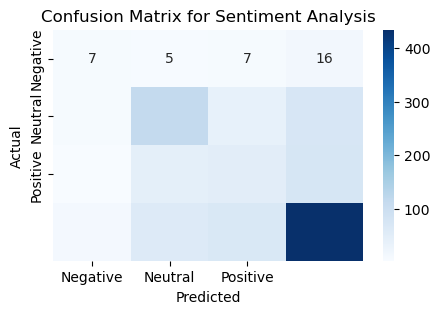

In [27]:
# Assuming y_test_sentiment and predicted_sentiment are already defined
conf_matrix_sentiment = confusion_matrix(y_test_sentiment, predicted_sentiment)

# Plot confusion matrix for sentiment analysis
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_sentiment, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()


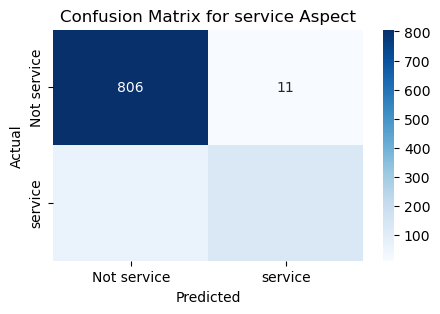

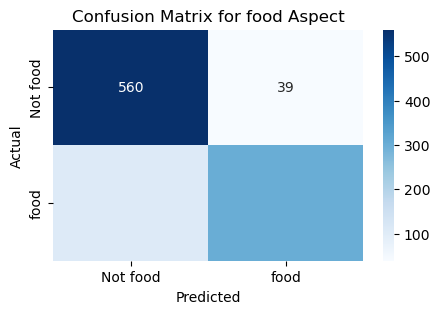

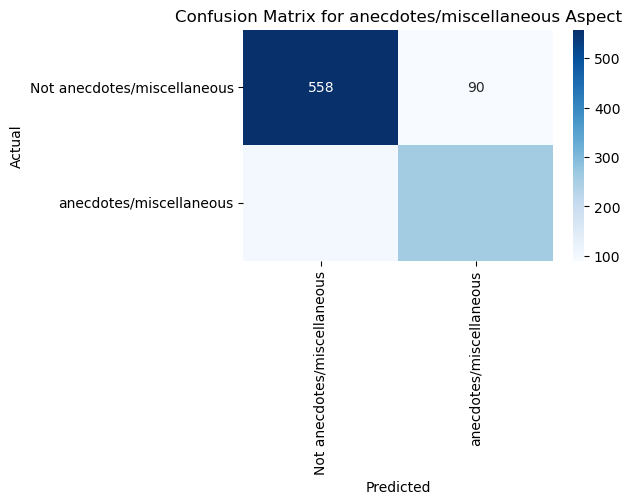

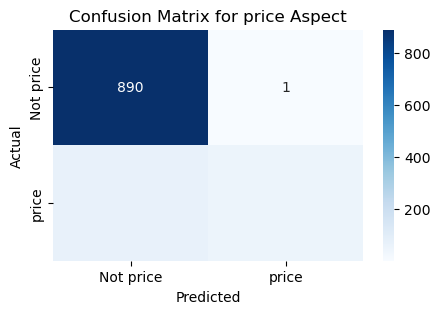

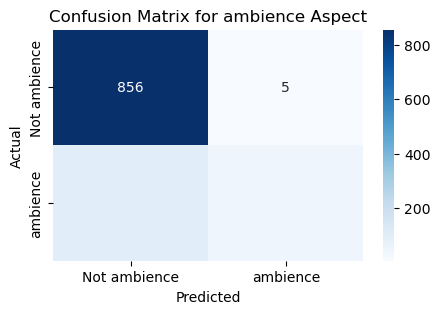

In [28]:
# Plot confusion matrix for aspect classification
for i, aspect in enumerate(aspect_labels):
    conf_matrix_aspect = confusion_matrix(y_test_aspect[:, i], predicted_aspect[:, i])
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix_aspect, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + aspect, aspect], yticklabels=['Not ' + aspect, aspect])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {aspect} Aspect')
    plt.show()

In [29]:
# Function to predict aspects and sentiment for new sentences
def predict_aspects_and_sentiment(new_sentences):
    # Apply preprocessing to new sentences
    new_sentences = [preprocess_text(sentence) for sentence in new_sentences]

    new_sentences_aspect_tfidf = vectorizer_aspect.transform(new_sentences)
    predicted_aspects = multi_label_classifier_aspect.predict(new_sentences_aspect_tfidf)
    
    new_sentences_sentiment_bow = vectorizer_sentiment.transform(new_sentences)
    predicted_sentiments = svm_classifier_sentiment.predict(new_sentences_sentiment_bow)
    
# Convert numerical predictions to aspect labels
    predicted_aspect_labels = []
    for aspects in predicted_aspects:
        labels = [aspect_labels[i] for i, val in enumerate(aspects) if val == 1]
        predicted_aspect_labels.append("|".join(labels))
    
    return predicted_aspects, predicted_sentiments, predicted_aspect_labels

In [30]:
# Example usage in Jupyter Notebook
new_sentences = ["The pasta was mouth-watering."]
predicted_aspects, predicted_sentiments, predicted_aspect_labels = predict_aspects_and_sentiment(new_sentences)
print(f"Predicted Aspects: {predicted_aspects}")
print(f"Predicted Sentiments: {predicted_sentiments}")
print(f"Predicted Aspect Labels: {predicted_aspect_labels}")

Predicted Aspects: [[0 1 0 0 0]]
Predicted Sentiments: ['positive']
Predicted Aspect Labels: ['food']
